# Toxicity signal analysis


In [30]:
from datasets import load_dataset
import cohere
import numpy as np
import os

EMBEDDING_MODEL = 'large'
BATCH_SIZE = 96
TEMPLATE = '{}'
co = cohere.Client(os.environ['COHERE_API_KEY'])

train_data = load_dataset('jigsaw_toxicity_pred',
                          data_dir='../datasets/jigsaw_toxicity_pred',
                          split='train[:10%]')
test_data = load_dataset('jigsaw_toxicity_pred',
                         data_dir='../datasets/jigsaw_toxicity_pred',
                         split='test[:20%]')


In [31]:
from sklearn.preprocessing import normalize


def compute_embedding(texts: list[str]) -> np.ndarray:
  """Compute cohere embeddings for a list of texts."""
  texts = [TEMPLATE.replace('{}', text) for text in texts]
  cohere_embeddings = co.embed(texts, truncate='START', model=EMBEDDING_MODEL).embeddings
  return np.array(cohere_embeddings)


def get_embeddings(dataset) -> np.ndarray:
  fname = f'{dataset.builder_name}_{dataset.split}_{EMBEDDING_MODEL}_embeddings.npy'
  try:
    embeddings = np.load(fname)
  except FileNotFoundError:
    data = dataset.map(lambda batch: {'x': compute_embedding(batch['comment_text'])},
                       batched=True,
                       batch_size=BATCH_SIZE)
    embeddings = np.array(data['x'])
    np.save(fname, embeddings)

  embeddings = normalize(embeddings).astype(np.float16)
  return embeddings

### Compute the embeddings


In [32]:
from sklearn.linear_model import LogisticRegression

train_embeddings = get_embeddings(train_data)
test_embeddings = get_embeddings(test_data)

model = LogisticRegression(class_weight='balanced', C=10, warm_start=True, max_iter=1_000)

## Train a model


In [33]:
def _make_balanced_data(train_data, sample_size_per_group):
  df = train_data.to_pandas()
  groups = df['toxic'].groupby(df['toxic']).groups
  positive_examples = groups[1][:sample_size_per_group]
  negative_examples = groups[0][:sample_size_per_group]
  positive_embeddings = train_embeddings[positive_examples]
  negative_embeddings = train_embeddings[negative_examples]
  positive_labels = np.ones(len(positive_embeddings))
  negative_labels = np.zeros(len(negative_embeddings))
  positive_text = df.loc[positive_examples]['comment_text']
  negative_text = df.loc[negative_examples]['comment_text']
  embeddings = np.concatenate([positive_embeddings, negative_embeddings])
  labels = np.concatenate([positive_labels, negative_labels])
  text = np.concatenate([positive_text, negative_text])
  return embeddings, labels, text

In [35]:
from sklearn.metrics import roc_auc_score

from src.utils import DebugTimer

SAMPLE_SIZE_PER_GROUP = 300
embeddings, labels, texts = _make_balanced_data(train_data, SAMPLE_SIZE_PER_GROUP)
print(len(embeddings), len(labels))
with DebugTimer('Training a model'):
  model.fit(embeddings, labels)

y_score = model.predict_proba(embeddings)[:, 1]
roc_auc = roc_auc_score(labels, y_score)
print(f'ROC AUC on train set, {len(embeddings)} examples: {roc_auc:.3f}')

test_labels = np.array(test_data['toxic'])
y_score = model.predict_proba(test_embeddings)[:, 1]
roc_auc = roc_auc_score(test_labels, y_score)
print(f'ROC AUC on test set, {len(test_labels)} examples: {roc_auc:.3f}')

600 600
Training a model took 0.035s.
ROC AUC on train set, 600 examples: 0.999
ROC AUC on test set, 12796 examples: 0.932


## Save the concept


In [36]:
from src.concepts.concept import Concept, Example

data = {}

for index, (label, text) in enumerate(zip(labels, texts)):
  id = str(index)
  ex = Example(label=bool(label), text=text, id=str(index))
  data[id] = ex

concept = Concept(namespace='local', concept_name='toxicity', type='text', data=data)

with open('gcs_cache/concept/local/toxicity/concept.json', 'w') as f:
  f.write(concept.json(exclude_none=True, exclude_unset=True))

(array([5860., 1456.,  769.,  555.,  423.,  301.,  250.,  234.,  203.,
         169.,  181.,  175.,  189.,  173.,  180.,  168.,  230.,  246.,
         309.,  725.]),
 array([3.09592849e-04, 5.02832292e-02, 1.00256866e-01, 1.50230502e-01,
        2.00204138e-01, 2.50177775e-01, 3.00151411e-01, 3.50125047e-01,
        4.00098684e-01, 4.50072320e-01, 5.00045957e-01, 5.50019593e-01,
        5.99993229e-01, 6.49966866e-01, 6.99940502e-01, 7.49914138e-01,
        7.99887775e-01, 8.49861411e-01, 8.99835048e-01, 9.49808684e-01,
        9.99782320e-01]),
 <BarContainer object of 20 artists>)

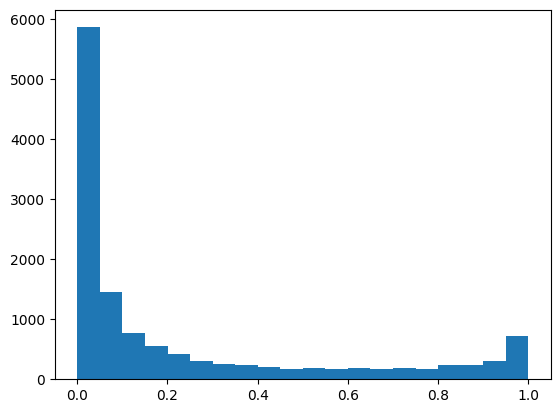

In [62]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.hist(y_score, bins=20)